## Load In Data & Import Relevent Libraries

In [3]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml import Pipeline
# Import the logistic regression model
from pyspark.ml.classification import LogisticRegression, LogisticRegressionModel
# Import the evaluation module
from pyspark.ml.evaluation import *
# Import the model tuning module
from pyspark.ml.tuning import *
import numpy as np
from pyspark.sql import functions as F
from pyspark.ml.feature import StringIndexer, OneHotEncoder, Tokenizer, RegexTokenizer, HashingTF, IDF
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.feature import StringIndexer, OneHotEncoder, Tokenizer, RegexTokenizer, HashingTF, IDF
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator


parquet_file_path = "gs://my-cis4130-rk/clean-new.parquet"


df = spark.read.parquet(parquet_file_path)


df = df.drop('timestamp_created', 'year', 'language','author_playtime_forever' )

## Cleaning & Imputing

In [4]:
def check_null_counts(df):
    numeric_columns = [item[0] for item in df.dtypes if item[1] in ['int', 'double', 'float']]
    
    # Count nulls and NaN for each column
    for column in numeric_columns:
        null_count = df.filter(col(column).isNull() | isnan(col(column))).count()
        if null_count > 0:
            print(f"Column {column} has {null_count} null/NaN values")

# Add this before feature processing
check_null_counts(df)


In [5]:

from pyspark.ml.feature import StringIndexer, OneHotEncoder, RegexTokenizer, HashingTF, IDF
from pyspark.ml.feature import VectorAssembler, StandardScaler, Imputer
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.sql.functions import col, isnan, when, count

from pyspark.sql.functions import col

# Cast the columns to correct types (int or double as needed)
df = df.withColumn("votes_up", col("votes_up").cast("int"))
df = df.withColumn("votes_funny", col("votes_funny").cast("int"))
df = df.withColumn("author_num_games_owned", col("author_num_games_owned").cast("int"))
df = df.withColumn("voted_up", col("voted_up").cast("double"))
df = df.withColumn("steam_purchase", col("steam_purchase").cast("double"))
df = df.withColumn("received_for_free", col("received_for_free").cast("double"))
df = df.withColumn("comment_count", col("comment_count").cast("int"))
df = df.withColumn("author_num_reviews", col("author_num_reviews").cast("int"))




from pyspark.ml.feature import Imputer
from pyspark.sql import functions as F

# Define numeric columns
numeric_cols = [
    "votes_up", 
    "votes_funny", 
    "author_num_games_owned",
    "comment_count",
    "author_num_reviews"
]

def impute_and_replace(df, columns=numeric_cols, strategy="mean"):
    
    # Create temporary column names for imputation
    temp_cols = [f"{c}_temp" for c in columns]
    
    # Initialize imputer with temporary column names
    imputer = Imputer(
        inputCols=columns,
        outputCols=temp_cols
    ).setStrategy(strategy)
    
    # Fit and transform the data
    df_temp = imputer.fit(df).transform(df)
    
    # Replace original columns with imputed values
    for original_col, temp_col in zip(columns, temp_cols):
        df_temp = df_temp.withColumn(
            original_col,
            F.coalesce(F.col(original_col), F.col(temp_col))
        )
    
    # Drop temporary columns
    df_final = df_temp.drop(*temp_cols)
    
    return df_final

# Example usage:

# Impute nulls while preserving original column names
df_imputed = impute_and_replace(df, strategy="mean")

# To verify results
#df_imputed.select(numeric_cols).show()


In [6]:
df = df_imputed

In [7]:
columns = ["game", "author_num_reviews", "author_num_games_owned", "review", "voted_up",
           "votes_up", "votes_funny", "weighted_vote_score", "comment_count",
           "steam_purchase", "received_for_free"]

#df_clean = df
for column in columns:
    df = df.filter(~col(column).isNull()).filter(~isnan(col(column)))


In [13]:
from pyspark.sql.functions import col

from pyspark.ml.feature import Binarizer

df = df.withColumn("weighted_vote_score", col("weighted_vote_score").cast("double"))

# Now apply the binarizer
binarizer = Binarizer(threshold=>.7, inputCol="weighted_vote_score", outputCol="binary_vote_score_1")
binarized_reviewScore_sdf = binarizer.transform(df)

df = binarized_reviewScore_sdf


SyntaxError: invalid syntax (3449656340.py, line 8)

In [15]:
from pyspark.sql.functions import when

df = df.withColumn("weighted_vote_score", col("weighted_vote_score").cast("double"))

# Create the binary column with a custom condition
df = df.withColumn(
    "c",
    when(col("weighted_vote_score") >= 0.7, 1).otherwise(0)
)


In [6]:


df = df.filter(F.col("language") == "english") 

In [7]:
from pyspark.sql.functions import col, isnan, when, trim

def to_null(c):
    return when(~(col(c).isNull() | isnan(col(c)) | (trim(col(c)) == "")), col(c))


df = df.select([to_null(c).alias(c) for c in df.columns]).na.drop()


## Filter out rows with empty game titles/invalid values

In [8]:
game_titles = "gs://sample_data_games/steam_game_reviews_top_200_games.csv"


temp = spark.read.csv(game_titles,header=True)

filter_values = [row["game"] for row in temp.select("game").distinct().collect()]

df = df.filter(df["game"].isin(filter_values))


## More Cleaning

In [10]:
if 'weighted_score' in filtered_df.columns:
    df = df.drop('weighted_score')

In [11]:
df = df.fillna({"votes_up": 0, "votes_funny": 0, "author_num_games_owned": 0,
                            "voted_up": 0, "steam_purchase": 0, "received_for_free": 0})

df = df.dropna(subset=["votes_up", "votes_funny", "author_num_games_owned", "voted_up", "steam_purchase", "received_for_free"])


In [ ]:
df = df.fillna({"votes_up": 0, "votes_funny": 0, "author_num_games_owned": 0,
                            "voted_up": 0, "steam_purchase": 0, "received_for_free": 0})

df = df.dropna(subset=["votes_up", "votes_funny", "author_num_games_owned", "voted_up", "steam_purchase", "received_for_free"])


## Pre-Processing Pipeline

In [13]:
# Step 1: Index and encode "game" column
indexer = StringIndexer(inputCol="game", outputCol="gameIndex")
encoder = OneHotEncoder(inputCols=["gameIndex"], outputCols=["gameVector"], dropLast=False)

# Step 2: Tokenize "review" column, and compute TF-IDF
regexTokenizer = RegexTokenizer(inputCol="review", outputCol="words", pattern="\\w+", gaps=False)
hashingTF = HashingTF(numFeatures=5000, inputCol="words", outputCol="word_features")
idf = IDF(inputCol="word_features", outputCol="tfidf_features", minDocFreq=2)

# Step 3: Assemble numeric features and scale them
assembler_scaling = VectorAssembler(
    inputCols=["votes_up", "votes_funny", "author_num_games_owned", "comment_count", "author_num_reviews"],
    outputCol="scaled_assemble",
    handleInvalid="keep"
)
scaler = StandardScaler(inputCol="scaled_assemble", outputCol="scaled_features", withMean=True, withStd=True)

# Step 4: Assemble all features into the final feature vector
assembler = VectorAssembler(
    inputCols=["scaled_features", "gameVector", "tfidf_features", "voted_up", "steam_purchase", "received_for_free"],
    outputCol="final_features",
    handleInvalid="keep"
)

# Create the pipeline with all stages
feature_pipeline = Pipeline(stages=[indexer, encoder, regexTokenizer, hashingTF, idf, assembler_scaling, scaler, assembler])

# Step 5: Fit the feature pipeline and transform the data
feature_pipeline_model = feature_pipeline.fit(df)
processed_df = feature_pipeline_model.transform(df)



## Checkpoint To Save Processed Data

In [16]:
checkpoint_dir = "gs://my-cis4130-rk/checkpoint/"
spark.sparkContext.setCheckpointDir(checkpoint_dir)

# Apply checkpointing to the DataFrame
checkpointed_df = processed_df.checkpoint()

# Trigger an action to materialize the checkpoint
checkpointed_df.count()  # This forces the checkpointing process to happen

# Save the checkpointed DataFrame as Parquet
checkpointed_df.write.parquet("gs://my-cis4130-rk/checkpoint/output-parquet/")


In [1]:
# Path to the checkpointed Parquet files
checkpoint_path = "gs://my-cis4130-rk/checkpoint/output-parquet/"

# Read the checkpointed data back into a DataFrame
restored_df = spark.read.parquet(checkpoint_path)




# Created Label Column to deal with class imbalances

In [2]:

from pyspark.sql.functions import when, col

restored_df = restored_df.withColumn("weighted_vote_score", col("weighted_vote_score").cast("double"))

# Create the binary column with a custom condition
restored_df = restored_df.withColumn(
    "target_variable",
    when(col("weighted_vote_score") <= .4, 1).otherwise(0)
)


In [17]:
restored_df.groupby('target_variable').count().show()

+---------------+--------+
|target_variable|   count|
+---------------+--------+
|              1|15985105|
|              0| 6552852|
+---------------+--------+



## Train & Evaluate Logistic Regression Model

In [8]:
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.feature import VectorAssembler

train_data, test_data = restored_df.randomSplit([0.8, 0.2])

# Step 2: Train the Logistic Regression model
lr = LogisticRegression(featuresCol="final_features", labelCol="target_variable")

# Fit the model to the training data
lr_model = lr.fit(train_data)

# Step 3: Make predictions on the test data
test_predictions = lr_model.transform(test_data)

# Step 4: Evaluate the model's performance using AUC
evaluator = BinaryClassificationEvaluator(labelCol="target_variable")
auc = evaluator.evaluate(test_predictions)
print(f"Test AUC: {auc}")


Test AUC: 0.6513028779119016


### Visualize ROC Curve

In [11]:
cm = test_predictions.groupby('target_variable').pivot('prediction').count().fillna(0).collect()
def calculate_recall_precision(cm):
    tn = cm[0][1] # True Negative
    fp = cm[0][2] # False Positive
    fn = cm[1][1] # False Negative
    tp = cm[1][2] # True Positive
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    f1_score = 2 * ((precision * recall) / (precision + recall))
    return accuracy, precision, recall, f1_score


print(calculate_recall_precision(cm))

(0.006044606418585113, 0.796987087517934, 0.0002478590090503118, 0.0004955639001994075)


Text(0.5, 1.0, 'ROC Curve')

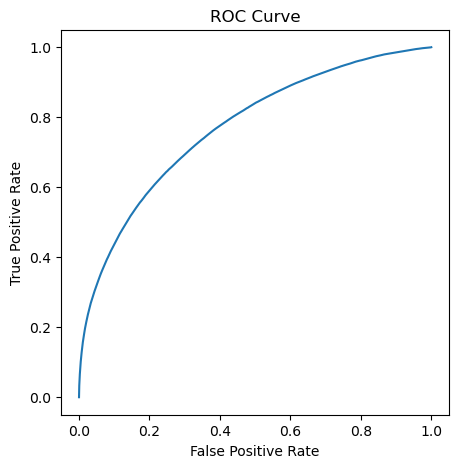

In [12]:

import matplotlib.pyplot as plt
plt.figure(figsize=(5,5))
plt.plot(lr_model.summary.roc.select('FPR').collect(),
lr_model.summary.roc.select('TPR').collect())
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("ROC Curve")

### Visualize Confusion Matrix 

In [15]:
# Step 7: Use the best model from cross-validation to make predictions
#best_model = cv_model.bestModel
train_data, test_data = restored_df.randomSplit([0.8, 0.2])

test_predictions = best_lr_model.transform(test_data)

# Step 8: Evaluate the model on the test set
test_auc = evaluator.evaluate(test_predictions)
print(f"Test AUC: {test_auc}")


Test AUC: 0.7837447483674547


In [9]:
predictions_df = test_predictions.select("prediction", "binary_vote_score")
predictions_pandas = predictions_df.toPandas()


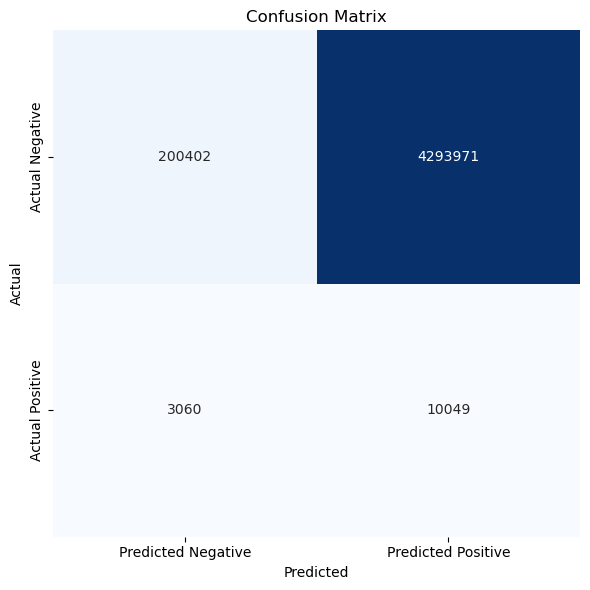

In [10]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Get the predictions and actual labels from the test data
#predictions = test_predictions.select("prediction", "binary_vote_score").toPandas()

# Extract the predicted labels (prediction column) and actual labels (binary_vote_score column)
y_pred = predictions_pandas['prediction']
y_true = predictions_pandas['binary_vote_score']

# Calculate the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Create a heatmap for the confusion matrix
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Predicted Negative", "Predicted Positive"], 
            yticklabels=["Actual Negative", "Actual Positive"], cbar=False)

# Add labels and title
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')

# Show the plot
plt.tight_layout()
plt.show()


## Re-train & Evaluate Logistic Regression Model with Hyperparameters

In [22]:
#train_data, test_data = restored_df.randomSplit([0.8, 0.2])

from pyspark.ml.classification import LogisticRegression

# Define the logistic regression model with the best hyperparameters
best_lr_model = LogisticRegression(
    featuresCol="final_features",
    labelCol="target_variable",
    regParam=0.01,
    maxIter=200
)

trained_model = best_lr_model.fit(train_data)



In [23]:
# Make predictions
predictions = trained_model.transform(test_data)

# Evaluate using BinaryClassificationEvaluator
from pyspark.ml.evaluation import BinaryClassificationEvaluator

evaluator = BinaryClassificationEvaluator(labelCol="target_variable", metricName="areaUnderROC")
full_auc = evaluator.evaluate(predictions)

print(f"Full Dataset AUC: {full_auc}")


Full Dataset AUC: 0.6502516294166856


### Get coefficients (weights) from the logistic regression model


In [13]:
coefficients = trained_model.coefficients.toArray()

# Get the list of feature names (after transformations in the pipeline)
feature_names = [
    "scaled_features", "gameVector", "voted_up", "steam_purchase", "received_for_free"
]

# Print the features and their corresponding importance (coefficients)
feature_importance = list(zip(feature_names, coefficients))
feature_importance = sorted(feature_importance, key=lambda x: abs(x[1]), reverse=True)

for feature, importance in feature_importance:
    print(f"Feature: {feature}, Coefficient: {importance}")


Feature: voted_up, Coefficient: 0.07889746676435956
Feature: received_for_free, Coefficient: 0.0248937153522092
Feature: gameVector, Coefficient: 0.005741199168862145
Feature: scaled_features, Coefficient: 0.0057307063757713215
Feature: steam_purchase, Coefficient: 0.0027737313914948476


### Visualize Feature Importance

/tmp/ipykernel_10595/53047684.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances, y=features, palette="viridis")


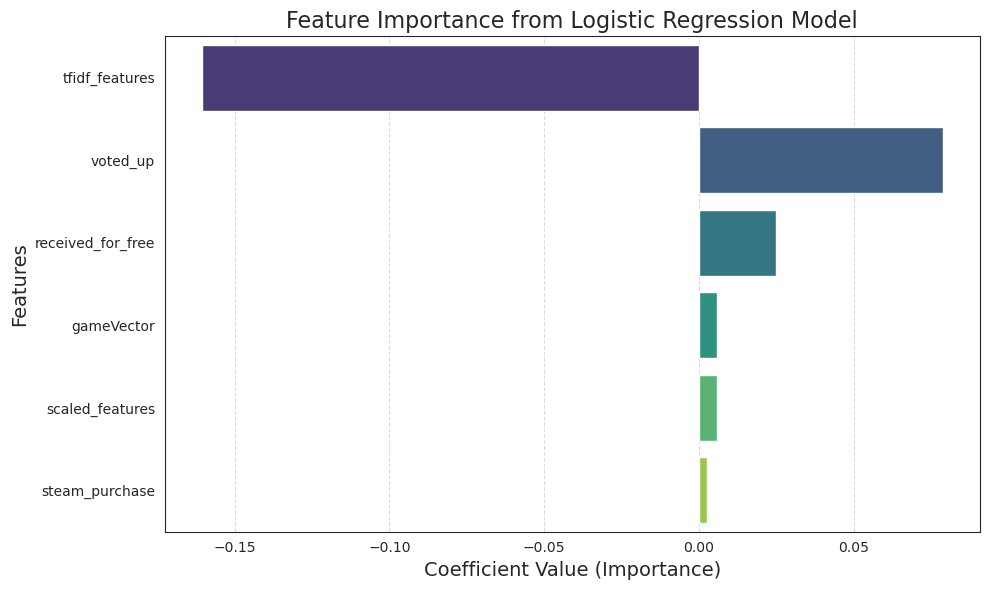

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming feature_importance is already calculated
# Convert the list of tuples into separate lists for plotting
features, importances = zip(*feature_importance)

# Plot the results
plt.figure(figsize=(10, 6))
sns.barplot(x=importances, y=features, palette="viridis")

# Add titles and labels
plt.title("Feature Importance from Logistic Regression Model", fontsize=16)
plt.xlabel("Coefficient Value (Importance)", fontsize=14)
plt.ylabel("Features", fontsize=14)

# Add grid lines for better readability
plt.grid(axis="x", linestyle="--", alpha=0.7)

plot_filename = "feature_importance.png"
plt.tight_layout()
plt.savefig(plot_filename, bbox_inches='tight', dpi=300)

# Show the plot
plt.tight_layout()
plt.show()


## Save Model

In [ ]:
# Define the GCS path where you want to save the model
gcs_path = "gs://my-cis4130-rk/model"
# Save the trained model to GCS
lr_model.save(gcs_path)
